# Grammar
Grammar rules object and finite grammar object.

In [1]:
from estnltk.finite_grammar.trees import Rule, Grammar

grammar = Grammar(start_symbols=['S'])
grammar.add(Rule('S', 'A'))
grammar.add(Rule('S', 'B'))
grammar.add(Rule('A', 'B F'))
grammar.add(Rule('B', 'G'))
grammar


Grammar:
	start: S
	terminals: F, G
	nonterminals: A, B, S
	max_depth: inf
Rules:
	S -> A	: 0, val: default_validator, dec: default_decorator
	S -> B	: 0, val: default_validator, dec: default_decorator
	A -> B F	: 0, val: default_validator, dec: default_decorator
	B -> G	: 0, val: default_validator, dec: default_decorator

# Phrase list generator
Generates all phrases of the finite grammar.

In [2]:
from estnltk.finite_grammar import phrase_list_generator

for phrase in phrase_list_generator(grammar, max_depth=float('inf')):
    print(phrase)

['G', 'F']
['G']


## Graph from layer

In [3]:
from estnltk import Text
from estnltk.layer import Layer
from estnltk.spans import Span

text = Text('a b c d e f g')

layer = Layer(name='test_grammar',
              attributes=['grammar_symbol']
              )
layer.add_span(Span(start= 0, end= 1, legal_attributes=['grammar_symbol'], grammar_symbol='A'))
layer.add_span(Span(start= 2, end= 3, legal_attributes=['grammar_symbol'], grammar_symbol='B'))
layer.add_span(Span(start= 4, end= 5, legal_attributes=['grammar_symbol'], grammar_symbol='C'))
layer.add_span(Span(start= 6, end= 7, legal_attributes=['grammar_symbol'], grammar_symbol='D'))
layer.add_span(Span(start= 8, end= 9, legal_attributes=['grammar_symbol'], grammar_symbol='E'))

text['test_grammar'] = layer
text['test_grammar']

Layer(name=test_grammar, spans=SL[Span(a, {'grammar_symbol': 'A'}),
Span(b, {'grammar_symbol': 'B'}),
Span(c, {'grammar_symbol': 'C'}),
Span(d, {'grammar_symbol': 'D'}),
Span(e, {'grammar_symbol': 'E'})])

Create a graph that represents the layer.

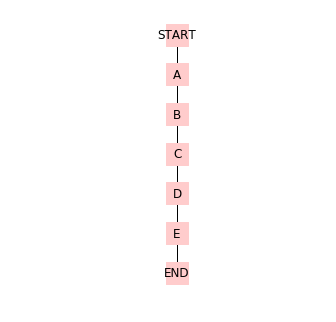

In [4]:
from estnltk.finite_grammar.layer_graph import layer_to_graph, plot_graph
from estnltk.finite_grammar.layer_graph import graph_to_parse_trees
from estnltk.finite_grammar.grammar import parse_graph

graph = layer_to_graph(text['test_grammar'])
plot_graph(graph,4)

Use grammar to parse the graph above. Don't solve conflicts between the nodes.

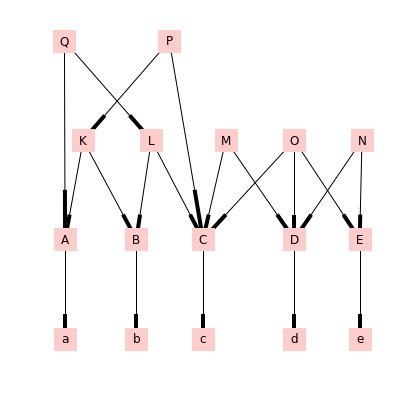

In [5]:
rules = []
rules.append(Rule('K', 'A B',   priority=1, group='g2'))
rules.append(Rule('L', 'B C',   priority=0, group='g2'))
rules.append(Rule('M', 'C D',   priority=2, group='g2'))
rules.append(Rule('N', 'D E',   priority=2, group='g2'))
rules.append(Rule('O', 'C D E', priority=3, group='g2'))
rules.append(Rule('P', 'K C',   priority=0, group='g3'))
rules.append(Rule('Q', 'A L',   priority=1, group='g3'))

grammar = Grammar(start_symbols=['M', 'N', 'O', 'P', 'Q'], rules=rules)

graph = layer_to_graph(text['test_grammar'])
parse_graph(graph, grammar, conflict_resolving=False, debug=False)

plot_graph(graph_to_parse_trees( graph), 5)

Use the same grammar to parse the same graph but also solve the conflicts. 

Note that
1. O is in conflict with M and N. Priority of O is lower and so O is removed.
2. P and Q are in conflict. Priority of Q is lower and so Q is removed.
3. M and N are in conflict, but priorities of M and N are equal, so none of them is removed.
4. L and M are in conflict, but in different groups, so none of them is removed.
5. L and K are in conflict, have the same group and different priorities, but are not listed as the start symbols of the grammar, so none of them is removed.


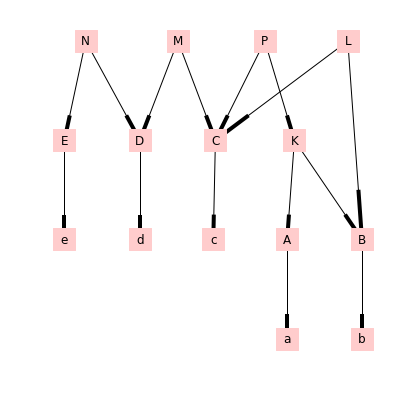

In [6]:
graph = layer_to_graph(text['test_grammar'])
parse_graph(graph, grammar, conflict_resolving=True, debug=False)
trees = graph_to_parse_trees(graph)
plot_graph(trees, 5)

## Grammar parsing tagger
Grammar parsing tagger uses all above to create a new layer.

In [7]:
from estnltk.taggers.grammar_parsing.grammar_parsing_tagger import GrammarParsingTagger
tagger = GrammarParsingTagger(grammar,'test_grammar', attributes=['name', 'priority', 'group'],
                              conflict_resolving=True)
tagger

GrammarParsingTagger(conflict_resolving=True)

In [8]:
tagger.tag(text)
text.parse

layer name,attributes,parent,enveloping,ambiguous,span count
parse,"name, priority, group",None,test_grammar,False,3
text,start,end,name,priority,group
a b c,0,5,P,None,None
c d,4,7,M,None,None
d e,6,9,N,None,None


# PhraseListTagger
## Example 1

In [9]:
from estnltk import Text
text_1 = Text('Patsient lasi jalga, sest vasaku jala suure varba pika \
               painutajalihase kõõluse rebend ajas tal kopsu üle maksa.')
text_1.analyse('morphology')

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [10]:
from estnltk.finite_grammar import PhraseListTagger

phrase_list = [
               ('jalg'),
               ('vasak', 'jalg',),
               ('parem', 'jalg',),
               ('kops',),
               ('vasak', 'kops'),
               ('parem', 'kops'),
               ('kõõlus',),
               ('lihas',),
               ('maks',),
               ('neer',),
               ('parem', 'neer'),
               ('vasak', 'neer'),
               ('varvas',),
               ('suur', 'varvas'),
              ]

def decorator(text, span, phrase):
    return {'match': phrase, 'dfsd':None}

def consistency_checker(text, span, phrase):
    return True

tagger = PhraseListTagger(layer_name='body_parts',
                          input_layer='morph_analysis',
                          input_attribute='lemma',
                          phrase_list=phrase_list,
                          attributes=('match',),
                          decorator=decorator,
                          consistency_checker=consistency_checker,
                          conflict_resolving_strategy= 'MAX')
tagger

PhraseListTagger(attributes=('match',), conflict_resolving_strategy=MAX, decorator=<function decorator at 0x7f7d80cd1e18>, input_attribute=lemma, input_layer=morph_analysis, layer_name=body_parts, phrase_list=14 phrases, validator=<function consistency_checker at 0x7f7d80cd17b8>)

In [11]:
tagger.tag(text_1)

Text(text="Patsient lasi jalga, sest vasaku jala suure varba pika                painutajalihase kõõluse rebend ajas tal kopsu üle maksa.")

In [12]:
text_1['body_parts']

Layer(name=body_parts, spans=SL[SL[SL[Span(vasaku, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'vasak', 'partofspeech': 'A', 'root': 'vasak', 'root_tokens': ('vasak',)})],
SL[Span(jala, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'jalg', 'partofspeech': 'S', 'root': 'jalg', 'root_tokens': ('jalg',)})]],
SL[SL[Span(suure, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'suur', 'partofspeech': 'A', 'root': 'suur', 'root_tokens': ('suur',)})],
SL[Span(varba, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'varvas', 'partofspeech': 'S', 'root': 'varvas', 'root_tokens': ('varvas',)})]],
SL[SL[Span(kõõluse, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'kõõlus', 'partofspeech': 'S', 'root': 'kõõlus', 'root_tokens': ('kõõlus',)})]],
SL[SL[Span(kopsu, {'clitic': '', 'ending': '0', 'form': 'adt', 'lemma': 'kops', 'partofspeech': 'S', 'root': 'kops', 'root_tokens': ('kops',)})]]])

Note that 'maksa' is not tagged. This is because Vabamorf thinks its lemma is 'maksma'.

## Example 2: postprocessing
Suppose that we want to postprocess the layer before adding it to the text object. Here we add an attribute 'latin_term' to the layer.

In [13]:
text = Text('Vasaku jala suure varba pika painutajalihase kõõluse rebend ajas patsiendi kopsu üle maksa.')
text.analyse('morphology')
latin_dict = {('suur', 'varvas'):'hallux', ('kõõlus',):'tendo', ('kops',):'pulmo'}

layer = tagger.tag(text, return_layer=True)
layer.attributes = ('match','latin_term')
for s in layer:
    s.latin_term = latin_dict[s.match]
text['body_parts'] = layer
text['body_parts']

Layer(name=body_parts, spans=SL[SL[SL[Span(suure, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'suur', 'partofspeech': 'A', 'root': 'suur', 'root_tokens': ('suur',)})],
SL[Span(varba, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'varvas', 'partofspeech': 'S', 'root': 'varvas', 'root_tokens': ('varvas',)})]],
SL[SL[Span(kõõluse, {'clitic': '', 'ending': '0', 'form': 'sg g', 'lemma': 'kõõlus', 'partofspeech': 'S', 'root': 'kõõlus', 'root_tokens': ('kõõlus',)})]],
SL[SL[Span(kopsu, {'clitic': '', 'ending': '0', 'form': 'adt', 'lemma': 'kops', 'partofspeech': 'S', 'root': 'kops', 'root_tokens': ('kops',)})]]])